In [165]:
import datetime
import os
import json
from datetime import timezone
from tzlocal import get_localzone
from typing import TypedDict, Annotated, List, Optional
import operator

from dotenv import load_dotenv;
from pydantic import  BaseModel, Field

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build



from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

from IPython.display import Image, display
from dateutil.parser import parse, ParserError

In [166]:
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY") 

SCOPES = ["https://www.googleapis.com/auth/calendar"]

if not all([groq_api_key, tavily_api_key]):
    raise ValueError("One or more required API keys (GROQ, TAVILY) are missing from the .env file!")


llm = ChatGroq(model="llama3-70b-8192", api_key=groq_api_key, temperature=0)
print("Groq LLM (Llama3-70b) configured and ready.")

Groq LLM (Llama3-70b) configured and ready.


In [167]:
class CalendarEvent(BaseModel):
    """Schema for a single calendar event."""
    summary: str = Field(description="The title or summary of the calendar event.")
    start_time: str = Field(description="The start time of the event in ISO format.")
    source: str = Field(description="The source of the calendar, either 'Google' or 'Apple'.")



def _get_google_credentials():
    """Gets valid Google API credentials."""
    creds = None
    if os.path.exists("token.json"):
        creds = Credentials.from_authorized_user_file("token.json", SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file("credentials.json", SCOPES)
            creds = flow.run_local_server(port=0)
        with open("token.json", "w") as token:
            token.write(creds.to_json())
    return creds



def _fetch_google_events(start_date: datetime.datetime, end_date: datetime.datetime) -> List[dict]:
    """Internal function to fetch events from Google Calendar within a specific date range."""
    try:
        creds = _get_google_credentials()
        service = build("calendar", "v3", credentials=creds)
        
        
        events_result = service.events().list(
            calendarId="primary",
            timeMin=start_date.isoformat(),
            timeMax=end_date.isoformat(),
            maxResults=250,
            singleEvents=True,
            orderBy="startTime"
        ).execute()
        
        events = events_result.get("items", [])
        if not events: return []

        output_events = []
        for event in events:
            start = event["start"].get("dateTime", event["start"].get("date"))
            event_model = CalendarEvent(summary=event.get("summary", "No Title"), start_time=start, source="Google")
            output_events.append(event_model.model_dump())
        return output_events
    except Exception as e:
        print(f"!!! Google Calendar Read Error: {e}")
        return [{"error": f"An error occurred while reading Google Calendar: {e}"}]


In [168]:
@tool
def list_upcoming_events(limit: Optional[int] = 15) -> str:
    """
    Lists the user's next upcoming events from today onwards from Google Calendar.
    Use this tool for general queries like 'list my events' or 'what's next?'.
    This tool does NOT take a specific date parameter.
    """
    print(f"--- Tool: list_upcoming_events called with limit={limit} ---")
    
    now = datetime.datetime.now(timezone.utc)
    search_end = now + datetime.timedelta(days=90) 

    google_events = _fetch_google_events(start_date=now, end_date=search_end)
    
    if not google_events or all('error' in e for e in google_events):
        return json.dumps([{"message": "No upcoming events found."}])

    valid_events = [e for e in google_events if 'error' not in e]
    
    if not limit: limit = 15
    events_to_return = valid_events[:limit]
    
    return json.dumps(events_to_return, indent=2)


@tool
def get_events_for_date(target_date: str) -> str:
    """
    Gets all Google Calendar events for a specific given date.
    Use this tool when the user asks about a particular date (e.g., 'tomorrow', 'August 22, 2025').
    This tool REQUIRES the 'target_date' parameter in 'YYYY-MM-DD' format.
    """
    print(f"--- Tool: get_events_for_date called with date='{target_date}' ---")
    
    try:
        parsed_target_date = parse(target_date).date()
    except ParserError:
        return json.dumps([{"error": f"Invalid date format provided: {target_date}"}])

    start_of_day = datetime.datetime.combine(parsed_target_date, datetime.time.min).replace(tzinfo=timezone.utc)
    end_of_day = datetime.datetime.combine(parsed_target_date, datetime.time.max).replace(tzinfo=timezone.utc)

    google_events = _fetch_google_events(start_date=start_of_day, end_date=end_of_day)
    valid_events = [e for e in google_events if 'error' not in e]
    
    if not valid_events:
        return json.dumps([{"message": f"No events found for {target_date}."}])

    return json.dumps(valid_events, indent=2)


@tool
def tavily_search(query: str) -> str:
    """
    A search engine tool. Use this for questions about real-time events, facts, or general knowledge.
    Do NOT use this for questions about the user's personal calendar or schedule.
    """
    print(f"--- Tool: tavily_search called with query: '{query}' ---")
    try:
        search = TavilySearch(max_results=3, api_key=tavily_api_key)
        results_str = search.invoke(query)
        
        if not results_str:
            return "No results found from web search."
        
        return results_str
        
    except Exception as e:
        print(f"!!! TAVILY SEARCH FAILED: {e}")
        return f"Error occurred during web search: {e}"



@tool
def create_google_event(summary: str, start_time_iso: str, end_time_iso: str) -> str:
    """
    Creates a new event on the user's primary Google Calendar.

    Args:
        summary (str): The title or summary of the event.
        start_time_iso (str): The start time of the event in ISO 8601 format (e.g., '2025-08-18T15:00:00').
        end_time_iso (str): The end time of the event in ISO 8601 format (e.g., '2025-08-18T16:00:00').
    """
    print(f"--- Tool: create_google_event called with: {summary}, {start_time_iso}, {end_time_iso} ---")
    try:
        creds = _get_google_credentials()
        service = build("calendar", "v3", credentials=creds)
        
        local_timezone = str(get_localzone())
        
        event_body = {
            'summary': summary,
            'start': {
                'dateTime': start_time_iso,
                'timeZone': local_timezone,
            },
            'end': {
                'dateTime': end_time_iso,
                'timeZone': local_timezone,
            },
        }

        created_event = service.events().insert(calendarId='primary', body=event_body).execute()
        
        print(f"--- Success: Event created. ID: {created_event.get('id')} ---")
        return f"Event '{summary}' was created successfully."

    except Exception as e:
        print(f"!!! Google Calendar Write Error: {e}")
        return f"An error occurred while creating the event in Google Calendar: {e}"



tools = [list_upcoming_events, get_events_for_date, create_google_event, tavily_search]
print(f"Defined {len(tools)} tools for the agent: {[t.name for t in tools]}")

Defined 4 tools for the agent: ['list_upcoming_events', 'get_events_for_date', 'create_google_event', 'tavily_search']


In [169]:
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]


llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools)


def agent_node(state):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


def should_continue(state):
    if state["messages"][-1].tool_calls:
        return "tools"
    return END

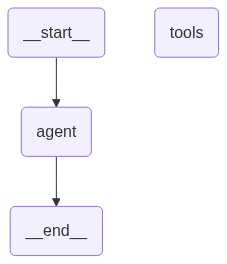

In [170]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [171]:
system_prompt_template = """
You are a multi-talented personal assistant. Today's date is {current_date}.

Your capabilities are:
1.  **General Conversation:** You can chat about any topic.
2.  **Calendar Management:** You can read and write to the user's Google Calendar.

**CRITICAL RULES FOR CALENDAR ACTIONS:**

**RULE 1: THE GOLDEN RULE OF DATES**
- You MUST ALWAYS use today's date ({current_date}) as the absolute reference point for ANY calculation involving relative dates like 'tomorrow' or 'next week'.
- NEVER use a date from a previous turn in the conversation as your reference, unless the user explicitly tells you to.

**RULE 2: RESOLVING DATES & RANGES**
- **Single Dates ('Next Tuesday', 'tomorrow'):** When you see 'next [day of week]', you MUST calculate the date of the first occurrence of that day after today. If today is the same day of the week, 'next [day]' refers to the day in the following week."
- **Date Ranges ('in 3 days', 'next 5 days'):** Phrases like **"in X days"**, **"next X days"**, or **"for the next X days"** ALWAYS define a date range. This range ALWAYS starts from today ({current_date}) and ends on the date that is X days in the future.

**RULE 3: CHOOSING & USING THE CORRECT TOOL**
- **For GENERAL requests** (e.g., "what are my next events?", "list my agenda"), you MUST use the `list_upcoming_events` tool. This tool does not need a date.
- **For SPECIFIC day requests** (e.g., "what's on for tomorrow?", "am I busy on next Tuesday?"), you MUST first resolve the date to 'YYYY-MM-DD' format as per RULE 1 & 2, and then call the `get_events_for_date` tool ONCE with that single date.
- **For DATE RANGE requests** (e.g., "what's happening in the next 3 days?"), you MUST first resolve the start and end dates of the range as per RULE 1 & 2. Then, you MUST call the `get_events_for_date` tool **multiple times**, once for each individual day in that range.

**RULE 4: CREATING EVENTS**
- To create an event with `create_google_event`, you must have a summary, a start time, and an end time. Ask clarifying questions if any detail is missing.
"""

messages = [SystemMessage(content="")]


print("Your assistant is ready. You can now start chatting.")
print("   Type 'quit' or 'exit' to end the conversation.")
print("-" * 50) 

while True:
    user_input = input("You: ")
    if user_input.lower() in ["quit", "exit"]:
        print("Assistant: Goodbye!")
        break


    print(f"You: {user_input}")

    today_str = datetime.date.today().isoformat()
    formatted_prompt = system_prompt_template.format(current_date=today_str)
    
    messages[0] = SystemMessage(content=formatted_prompt)

    messages.append(HumanMessage(content=user_input))

    state = {"messages": messages}
    
    final_state = app.invoke(state)

    final_response = final_state["messages"][-1]
    messages.append(final_response)

    print(f"Assistant: {final_response.content}")

Your assistant is ready. You can now start chatting.
   Type 'quit' or 'exit' to end the conversation.
--------------------------------------------------
You: Hi
Assistant: Hi! How can I assist you today?
You: Do I have any appointment today
--- Tool: get_events_for_date called with date='2025-08-17' ---
Assistant: You don't have any appointments today. Your calendar is clear for the day!
You:   What do I have scheduled for tomorrow?
--- Tool: get_events_for_date called with date='2025-08-18' ---
Assistant: You have an appointment with the doctor tomorrow at 3:30 AM.
You: Do I have any event on 26.08.2025
--- Tool: get_events_for_date called with date='2025-08-26' ---
Assistant: You have an event scheduled on 26.08.2025. It's a breakfast event starting at 10:00 AM.
You: What do I have scheduled for next Tuesday ?
--- Tool: get_events_for_date called with date='2025-08-20' ---
Assistant: You have a dentist appointment on next Tuesday, August 20, 2025, at 9:30 AM.
You: Show me my schedul